In [1]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
from sklearn.preprocessing import StandardScaler,LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score,f1_score,recall_score,confusion_matrix
from sklearn.model_selection import train_test_split,GridSearchCV,RandomizedSearchCV
import graphviz
import dtreeviz

In [2]:
data = pd.read_csv(r"D:\ArcgisData\pred_soildeep\deep_table\point_table.csv")

In [3]:
data

,OID_,lon,lat,deep,category,classname,classvalue
0,1,482528.138642,2.888584e+06,120.0,2,厚,2
1,2,503583.829632,2.889170e+06,120.0,2,厚,2
2,3,482098.746661,2.889842e+06,123.0,2,厚,2
3,4,489066.667511,2.890606e+06,120.0,2,厚,2
4,5,481804.806723,2.894214e+06,122.0,2,厚,2
...,...,...,...,...,...,...,...
9564,9565,216961.755086,2.846550e+06,120.0,2,厚,2
9565,9566,243422.772386,2.776497e+06,120.0,2,厚,2
9566,9567,213275.354187,2.858251e+06,120.0,2,厚,2
9567,9568,198803.380216,2.754365e+06,120.0,2,厚,2


In [4]:
# 去除重复数据
data.drop_duplicates(subset=list(data.columns)[1:], keep='first', inplace=True)
data

,OID_,lon,lat,deep,category,classname,classvalue
0,1,482528.138642,2.888584e+06,120.0,2,厚,2
1,2,503583.829632,2.889170e+06,120.0,2,厚,2
2,3,482098.746661,2.889842e+06,123.0,2,厚,2
3,4,489066.667511,2.890606e+06,120.0,2,厚,2
4,5,481804.806723,2.894214e+06,122.0,2,厚,2
...,...,...,...,...,...,...,...
9564,9565,216961.755086,2.846550e+06,120.0,2,厚,2
9565,9566,243422.772386,2.776497e+06,120.0,2,厚,2
9566,9567,213275.354187,2.858251e+06,120.0,2,厚,2
9567,9568,198803.380216,2.754365e+06,120.0,2,厚,2


In [5]:
data.columns

Index(['OID_', 'lon', 'lat', 'deep', 'category', 'classname', 'classvalue'], dtype='object')

In [6]:
# 改写分类字段的类型
data['classvalue']=data['classvalue'].astype('category')

In [7]:
X = data[['lon', 'lat']]
y = data[['classvalue']]

In [8]:
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2,random_state=42)

In [ ]:
# 定义随机森林超参数的取值范围
param_dist = {
    'n_estimators': np.arange(10, 1000, 10),
    'max_features': [1.0],
    'max_depth': [None] + list(np.arange(1, 28)),
    'min_samples_split': np.arange(2, 21),
    'min_samples_leaf': np.arange(1, 21),
    'bootstrap': [True, False]
}

# 创建随机森林回归器
clf = RandomForestClassifier()

# 使用RandomizedSearchCV来寻找最佳参数
random_search = RandomizedSearchCV(clf, param_distributions=param_dist, n_iter=500, cv=5, verbose=1, random_state=42, n_jobs=-1)
random_search.fit(X_train, y_train)

# 打印最佳参数
print('Best Parameters: \n', random_search.best_params_)

# 使用最佳参数对测试集进行评估
best_clf = random_search.best_estimator_
score = best_clf.score(X_test, y_test)
print('Test accuracy:', score)


In [10]:
# 使用最优参数训练RandomForestRegressor模型
rf = RandomForestClassifier(n_estimators=820, min_samples_split=8, min_samples_leaf= 3, max_features=1.0, max_depth=24, bootstrap= True)
rf.fit(X_train,y_train)
y_test_pred = rf.predict(X_test)
y_train_pred = rf.predict(X_train)
accuracy_score(y_test,y_test_pred),accuracy_score(y_train,y_train_pred)

C:\Users\Runker\AppData\Local\Temp\ipykernel_16700\481705654.py:3: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


(0.9670502092050209, 0.9709728033472803)

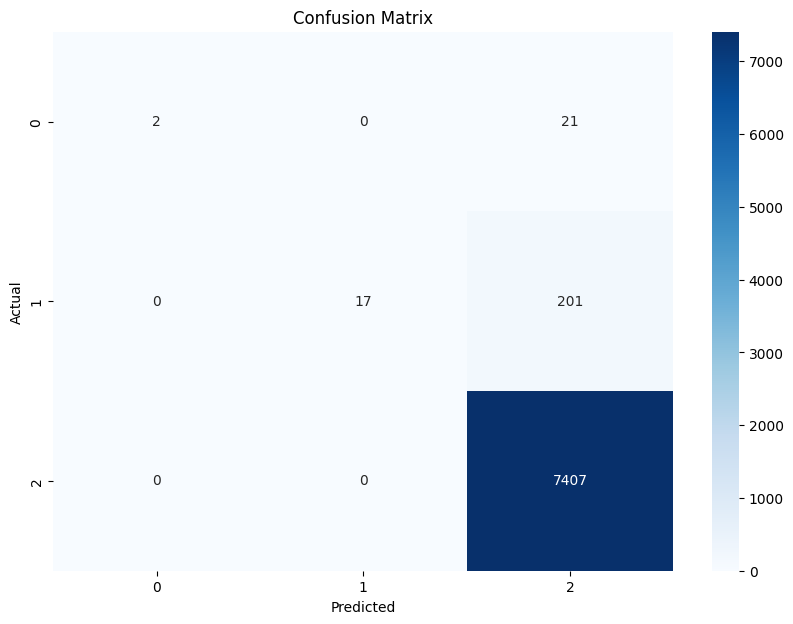

In [11]:
# 绘制混淆矩阵
cm = confusion_matrix(y_train, y_train_pred)
plt.figure(figsize=(10,7))
sns.heatmap(cm, annot=True, fmt='g', cmap="Blues")
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion Matrix')
plt.show()

(0.0, 1.0)

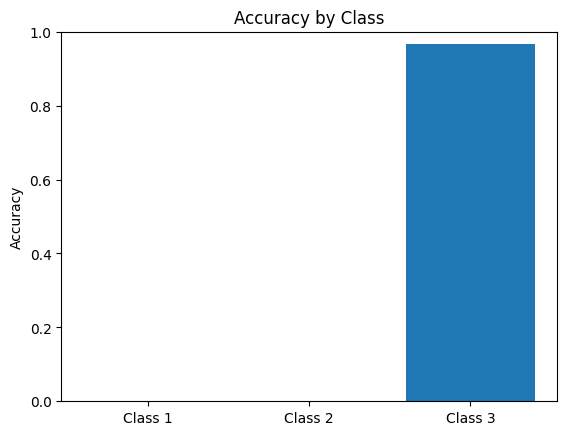

In [13]:
# 计算混淆矩阵
cm = confusion_matrix(y_test, y_test_pred)

# 计算每个类别的准确率
accuracies = []
for i in range(len(cm)):
    tp = cm[i, i]
    total = sum(cm[i, :]) + sum(cm[:, i]) - tp
    accuracies.append(tp / total if total > 0 else 0)

# 绘制每个类别的准确率图
categories = ['Class 1', 'Class 2', 'Class 3']
plt.bar(categories, accuracies)
plt.ylabel('Accuracy')
plt.title('Accuracy by Class')
plt.ylim(0, 1) # 确保y轴从0到1

(0.0, 1.0)

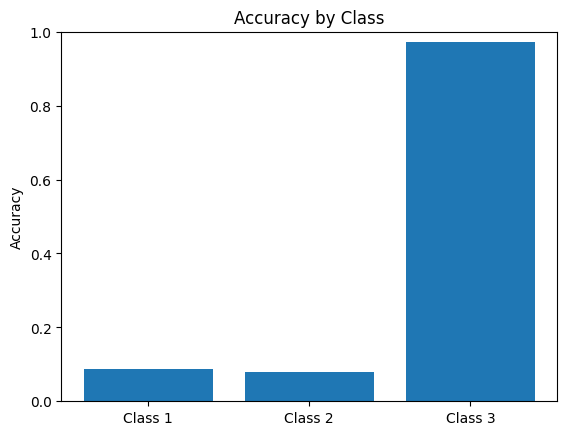

In [14]:
# 计算混淆矩阵
cm = confusion_matrix(y_train, y_train_pred)

# 计算每个类别的准确率
accuracies = []
for i in range(len(cm)):
    tp = cm[i, i]
    total = sum(cm[i, :]) + sum(cm[:, i]) - tp
    accuracies.append(tp / total if total > 0 else 0)

# 绘制每个类别的准确率图
categories = ['Class 1', 'Class 2', 'Class 3']
plt.bar(categories, accuracies)
plt.ylabel('Accuracy')
plt.title('Accuracy by Class')
plt.ylim(0, 1) # 确保y轴从0到1